In [7]:
import os
import sys
import glob
import math

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

# for rugarch
import rpy2
import os
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

base = importr('base')
rugarch = importr("rugarch", lib_loc = "C:/Users/suare/OneDrive/Documents/asuare/R/win-library/3.6")

%matplotlib inline

In [8]:
 def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

def _get_best_model(TS):
    # TODO: Nada de rolling window aqui. quiza habria que hacerla en algun lado. evluar la idea de: https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(1) # [0] # we'll use arma-garch, so not d (= 0)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

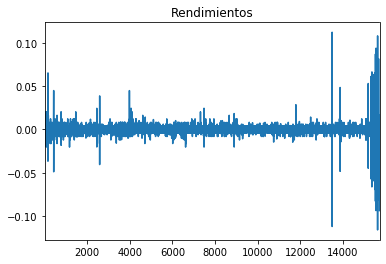

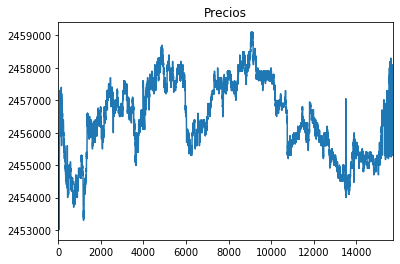

In [9]:
regex = '20170717'
fpattern = f'C:\\Users\\suare\\MEGA\\PhD\\1 Code and data\\data\\raw\\quantquote\\one_second_level\\242321_csv\\{regex}\\spy.csv'
colnames=['Time','Open','High','Low','Close','Volume','Suspicious']
sp500 = pd.concat(list(pd.read_csv(f, names=colnames) for f in glob.glob(fpattern)), ignore_index=True)
# regex='DOWJONES_(2015-01-01_to_2015-12-31)_indicators.csv.gz'
# path=os.sep.join(['G:','My Drive','PhD_Andres','Datos','quantquote','processed_data','2_result','minutes','15min-level','DOWJONES'])
# fpattern = os.sep.join([path,regex])
# sp500 = pd.read_csv(fpattern, compression='gzip')

returns = 100 * sp500['Close'].pct_change().dropna()   # pct_change es para rendimientos
returns.plot(title="Rendimientos")
plt.show()
prices = sp500['Close'].dropna() 
prices.plot(title='Precios', label ='Time')   # TODO: if it crashes, remove var y=Time
plt.show()
data =  prices

In [10]:
mode = 'returns'

# train the standardization
df = data.to_frame()
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df)
print(f'Min: {min_max_scaler.data_min_[0]}, Max: {min_max_scaler.data_max_[0]}') 

if mode=='returns':    
    TS = pd.DataFrame(np.log(data/data.shift(1))).reset_index(drop=True)#.dropna().reset_index(drop=True)
else:     
    # standardization the dataset
    TS = pd.DataFrame(min_max_scaler.transform(df)).reset_index(drop=True)  # .dropna().reset_index(drop=True)
TS = TS[TS.columns[0]].apply(lambda x: 0 if math.isnan(x) else x)                                                                  


Min: 2453000.0, Max: 2459100.0


In [11]:
res_tup = (4, 0, 3) # _get_best_model(TS) 
order = res_tup[1]
model = res_tup[2]
order

0

In [12]:
tsplot(model.resid, lags=30)

AttributeError: 'int' object has no attribute 'resid'

In [13]:
tsplot(model.resid**2, lags=30)

AttributeError: 'int' object has no attribute 'resid'

In [14]:
# Now we can fit the arch model using the best fit arima model parameters
p_, q_ = 4, 3 # order[0], order[2]
# o_ = order[1]

# Initialize R GARCH model
garch_spec = rugarch.ugarchspec(
    #mean_model=robjects.r(f'list(arimaOrder=c({p_},{o_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    mean_model=robjects.r(f'list(armaOrder=c({p_},{q_}), include.mean=T)'), # Using student T distribution usually provides better fit
    variance_model=robjects.r('list(garchOrder=c(1,1))'),    
    distribution_model='sged')  # 'std'

#If you have looked at the package vignette, you would have seen that package rugarch estimates ARFIMA(p,d,q) 
# model with 0<d<1. So it is not possible to set the integration order higher than one. 
# If you want to keep the value d fixed set fixed.pars=list(arfima=d). 
# For that naturally you need to set arfima=TRUE in the argument mean.model

print(garch_spec)



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(1,1)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(4,0,3)

Include Mean		: TRUE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  sged 

Includes Skew	:  TRUE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 





In [15]:
# Used to convert training set to R list for model input
numpy2ri.activate()
forecast_horizon = 100

# Train R GARCH model on returns as %
garch_fitted = rugarch.ugarchfit(
    spec=garch_spec,
    data=np.array(TS),
    out_sample=forecast_horizon
)
numpy2ri.deactivate()

In [16]:
print(garch_fitted)



*---------------------------------*

*          GARCH Model Fit        *

*---------------------------------*



Conditional Variance Dynamics 	

-----------------------------------

GARCH Model	: sGARCH(1,1)

Mean Model	: ARFIMA(4,0,3)

Distribution	: sged 



Optimal Parameters

------------------------------------

        Estimate  Std. Error    t value Pr(>|t|)

mu      0.000000    0.000000   0.477377  0.63309

ar1    -0.624523    0.024766 -25.216618  0.00000

ar2    -0.695196    0.013770 -50.487723  0.00000

ar3    -0.010181    0.024153  -0.421511  0.67338

ar4     0.024887    0.011261   2.209930  0.02711

ma1     0.204571    0.024071   8.498759  0.00000

ma2     0.439486    0.010962  40.091467  0.00000

ma3    -0.269267    0.026487 -10.165952  0.00000

omega   0.000000    0.000000   0.001023  0.99918

alpha1  0.049907    0.003413  14.624322  0.00000

beta1   0.899617    0.003393 265.131404  0.00000

skew    0.807089    0.007932 101.752373  0.00000

shape   1.269461    0.013167

In [17]:
print('Showing ARMA-GARCH coefficients:')
print(garch_fitted.slots['fit'].rx2('coef'))

Showing ARMA-GARCH coefficients:
           mu           ar1           ar2           ar3           ar4 

 6.708121e-08 -6.245229e-01 -6.951963e-01 -1.018093e-02  2.488707e-02 

          ma1           ma2           ma3         omega        alpha1 

 2.045713e-01  4.394856e-01 -2.692673e-01  4.259008e-11  4.990728e-02 

        beta1          skew         shape 

 8.996170e-01  8.070893e-01  1.269461e+00 



In [18]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [26]:
# TESTING STUFF 18-09-2019

print(garch_fitted.slots['fit'].rx2('coef'))
rugarch.setfixed=(rugarch.getspec(garch_fitted), garch_fitted.slots['fit'].rx2('coef'))

# Forecast 
garch_f1 = rugarch.ugarchforecast(
    spec=rugarch.getspec(garch_fitted),
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

           mu           ar1           ar2           ar3           ar4 

 6.708121e-08 -6.245229e-01 -6.951963e-01 -1.018093e-02  2.488707e-02 

          ma1           ma2           ma3         omega        alpha1 

 2.045713e-01  4.394856e-01 -2.692673e-01  4.259008e-11  4.990728e-02 

        beta1          skew         shape 

 8.996170e-01  8.070893e-01  1.269461e+00 



RRuntimeError: Error in UseMethod("ugarchforecast") : 
  no applicable method for 'ugarchforecast' applied to an object of class "c('uGARCHspec', 'GARCHspec', 'rGARCH')"


In [ ]:
## http://www.unstarched.net/r-examples/rugarch/a-short-introduction-to-the-rugarch-package/
numpy2ri.activate()
filt1 = rugarch.ugarchfilter(spec=rugarch.getspec(garch_fitted), data=np.array(TS), n_old = len(TS))
numpy2ri.deactivate()

filt1 = ugarchfilter(spec, sp500ret[1:1200, ], n.old = 1000)
filt2 = ugarchfilter(spec, sp500ret[1001:1200, ])
# then forecast


In [ ]:
# Model's fitted standard deviation values
fitted_minute_volatility = np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()
minute_volatility_residuals = np.array(garch_fitted.slots['fit'].rx2('residuals')).flatten()
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()

# Forecast 
garch_forecast = rugarch.ugarchforecast(
    garch_fitted,
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [ ]:
np.array(garch_fitted.slots['fit'].rx2('sigma')).flatten()

In [ ]:
tuple(garch_fitted.slotnames())

In [ ]:
tuple(garch_fitted.slots['fit'].names)

In [ ]:
tuple(garch_fitted.slots['model'].names)

In [ ]:
rugarch.getspec(garch_fitted).slots

In [ ]:
rugarch.ugarchspec()

In [ ]:
print(rugarch.getspec(garch_fitted))

In [ ]:
rugarch.

In [ ]:
# Forecast 
garch_forecast = rugarch.ugarchforecast(spec=garch_spec,
    data=
    n_ahead=1,
    n_roll=forecast_horizon - 1
)

# Model's forecasted standard deviation values
forecasted_minute_volatility = np.array(garch_forecast.slots['forecast'].rx2('sigmaFor')).flatten()
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()

In [ ]:
garch_fitted.slots['fit'].rx2('coef')

In [ ]:
rugarch.getspec(garch_fitted)

In [ ]:
output = pd.DataFrame({
    'actual': list(np.array(TS)),
    'model': np.append(fitted, forecast),
})

plt.plot(output['actual'][:-forecast_horizon], label='Train')
plt.plot(output['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(output['model'][:-forecast_horizon], label='Fitted')
plt.plot(output['model'][-forecast_horizon - 1:], label='Forecasted')
plt.legend()
plt.show()

In [ ]:
tsplot(minute_volatility_residuals, lags=30)

In [ ]:
tsplot(minute_volatility_residuals**2, lags=30)

In [ ]:
# how to reconstruct prices
df = pd.DataFrame() 
df['Close'] = data[:-forecast_horizon] # data
fitted = np.array(garch_fitted.slots['fit'].rx2('fitted.values')).flatten()
df['ts_logr_na0'] = TS
df['logr_na0'] = fitted # TS

# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
df

# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
fitted_reconstructed = df['reconstructed_price']
df

In [ ]:
# reconstructing forecasting
df = pd.DataFrame() 
df['Close'] = data[-(forecast_horizon):] # data
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
df['logr_na0'] = forecast # TS
# aqui reconstruimos los returns en precios (1) y quitamos la escala logaritmica (2).
# esta reconstruccion sigue normalizada (dividida por el primer precio que hubo)
df['cuml_log']= np.cumsum(df.logr_na0 * -1) # 1
df['reconstructed_price_norm'] = np.exp(df.cuml_log) # 2
# multiplicamos todos los valores por dicho valor y listo.
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
df

In [ ]:
# reconstructing forecasting
df = pd.DataFrame() 
df['Close'] = data[-(forecast_horizon):-(forecast_horizon)+1] # data
forecast = np.array(garch_forecast.slots['forecast'].rx2('seriesFor')).flatten()
df['logr_na0'] = forecast[0] 
df['reconstructed_price_norm'] = np.exp(df.logr_na0 * -1) #
df['reconstructed_price'] = df['Close'].values[0] * df.reconstructed_price_norm
df['reconstructed_price'] = df['reconstructed_price'].astype(int)
# making sure that the model adaps well
df[['Close','reconstructed_price']].plot()
df.head()

In [ ]:
# reconstructing forecasting
reconstructed_price = int(df['Close'].values[0] * np.exp(forecast[0] * -1))
print(f'orig: {data[-(forecast_horizon):-(forecast_horizon)+1].values[0]}   /  rec price: {reconstructed_price}')

In [ ]:
df['Close'].values[0]

In [ ]:
df['reconstructed_price'].values[0]

In [ ]:
fitted[0]

In [ ]:
import random
series = list()
for i in range(100000):
    series.append(random.randrange(-1,3))
max(series)

In [ ]:
rugarch.getspec(model)